# CIFAR10 Transfer Learning based Classifier

This notebook outlines the steps to build a classifier to leverage concepts of Transfer Learning by utilizing a pretrained Deep-CNN. 
Particularly in this case based on VGG16

In [40]:
# Pandas and Numpy for data structures and util fucntions
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

import cnn_utils as utils
from model_evaluation_utils import get_metrics

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [41]:
import tensorflow as tf
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from tensorflow.keras.models import Model
from keras.applications import DenseNet121
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
#from keras.utils import np_utils

In [42]:
pip install np_utils

In [43]:
import np_utils

## Load and Prepare DataSet

In [44]:
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [45]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

Split training dataset in train and validation sets

In [46]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

Transform target variable/labels into one hot encoded form

In [47]:
from keras.utils import to_categorical

In [48]:
Y_train = to_categorical(y_train, NUM_CLASSES)
Y_val = to_categorical(y_val, NUM_CLASSES)
Y_test = to_categorical(y_test, NUM_CLASSES)

### Preprocessing

Since we are about to use DenseNet121 as a feature extractor, the minimum size of an image it takes is 48x48.
We utilize ```scipy`` to resize images to required dimensions

In [49]:
from skimage import transform
X_train = np.array([transform.resize(x, 
                                     (48, 48)) for x in X_train])
X_val = np.array([transform.resize(x, 
                                   (48, 48)) for x in X_val])
X_test = np.array([transform.resize(x, 
                                    (48, 48)) for x in X_test])

## Prepare the Model

* Load VGG16 without the top classification layer
* Prepare a custom classifier
* Stack both models on top of each other

In [50]:
base_model = DenseNet121(weights='imagenet', 
                       include_top=False, 
                       input_shape=(48, 48, 3))

29084464/29084464 [==============================] - 5s 0us/step


In [51]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 54, 54, 3)            0         ['input_2[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 24, 24, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 24, 24, 64)           256       ['conv1/conv[0][0]']

In [53]:
# Extract the last layer from third block of ResNet152V2 model
last = base_model.get_layer('conv2_block3_1_bn').output

In [54]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)

Since our objective is to only train the custom classifier, we freeze the layers of VGG16

In [55]:
for layer in base_model.layers:
     layer.trainable = False

In [56]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [57]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 54, 54, 3)            0         ['input_2[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 24, 24, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 24, 24, 64)           256       ['conv1/conv[0][0]']    

## Data Augmentation

To help model generalize and overcome the limitations of a small dataset, we prepare augmented datasets using 
```keras ``` utilities

In [58]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [59]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train, 
                                     batch_size=BATCH_SIZE)

In [60]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

## Train the Model

In [61]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/20
1328/1328 [==============================] - 54s 27ms/step - loss: 0.3049 - accuracy: 0.2253 - val_loss: 0.2678 - val_accuracy: 0.3403
Epoch 2/20
1328/1328 [==============================] - 37s 28ms/step - loss: 0.2665 - accuracy: 0.3503 - val_loss: 0.2482 - val_accuracy: 0.4034
Epoch 3/20
1328/1328 [==============================] - 36s 27ms/step - loss: 0.2557 - accuracy: 0.3879 - val_loss: 0.2386 - val_accuracy: 0.4342
Epoch 4/20
1328/1328 [==============================] - 36s 27ms/step - loss: 0.2488 - accuracy: 0.4094 - val_loss: 0.2358 - val_accuracy: 0.4383
Epoch 5/20
1328/1328 [==============================] - 35s 26ms/step - loss: 0.2431 - accuracy: 0.4295 - val_loss: 0.2310 - val_accuracy: 0.4497
Epoch 6/20
1328/1328 [==============================] - 35s 26ms/step - loss: 0.2404 - accuracy: 0.4355 - val_loss: 0.2255 - val_accuracy: 0.4702
Epoch 7/20
1328/1328 [==============================] - 36s 27ms/step - loss: 0.2374 - accuracy: 0.4451 - val_loss: 0.2223 -

## Analyze Model Performance

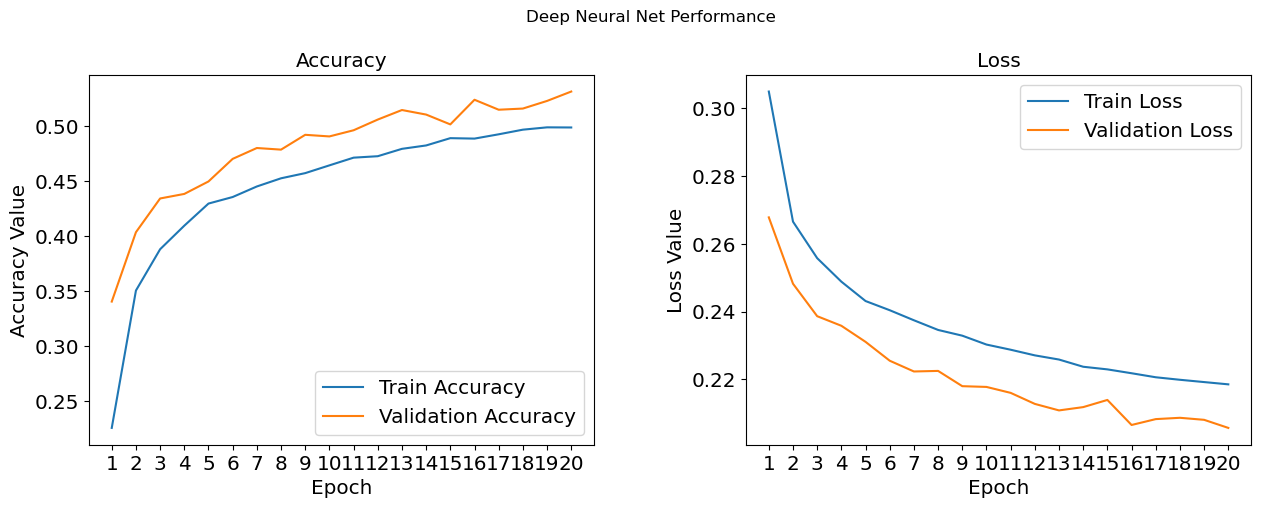

In [62]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [63]:
predictions = model.predict(X_test/255.)

313/313 [==============================] - 8s 22ms/step


In [64]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [65]:
get_metrics(true_labels=y_test, 
                predicted_labels=predictions)

Accuracy: 0.5242
Precision: 0.5315
Recall: 0.5242
F1 Score: 0.5178


## Visualize Predictions

In [66]:
classes=['aircraft', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'hours', 'truck']

In [67]:
utils.plot_predictions(model=model,dataset=X_test/255.,
                       dataset_labels=Y_test,
                       label_dict=label_dict,
                       batch_size=16,
                       grid_height=4,
                       grid_width=4)

AttributeError: module 'cnn_utils' has no attribute 'plot_predictions'